# **중고차 가격 예측 경진대회**
- 코드실행은 Google Colab의 CPU, Standard RAM 환경에서 진행했습니다.
- 작성자 : standing-o
- 수정 : `company`, `paint`, `location`, `engine` 변수 핸들링

## **0. Import Packages**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install h5py
!pip install typing-extensions
!pip install wheel
!pip install folium==0.2.1
!pip install markupsafe==2.0.1
!pip install -U pandas-profiling
!pip install catboost
!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import pandas_profiling
import seaborn as sns
import random as rn
import os
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from collections import Counter
from pycaret.regression import *

%matplotlib inline
warnings.filterwarnings(action='ignore')

In [4]:
print("numpy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
print("matplotlib version: {}". format(matplotlib.__version__))
print("scikit-learn version: {}". format(sklearn.__version__))

numpy version: 1.21.6
pandas version: 1.3.5
matplotlib version: 3.2.2
scikit-learn version: 0.23.2


In [5]:
# reproducibility
seed_num = 42 
np.random.seed(seed_num)
rn.seed(seed_num)
os.environ['PYTHONHASHSEED']=str(seed_num)

## **1. Load and Check Dataset**

In [6]:
train = pd.read_csv('/content/drive/MyDrive/Forecasting_price/dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Forecasting_price/dataset/test.csv')

print(train.shape)
train.head()

(1015, 11)


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


In [ ]:
pr = train.profile_report()
pr.to_file('/content/drive/MyDrive/Forecasting_price/pr_report.html')
pr

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### **Summary of Pandas profiling : Alert**
#### High correlation
`odometer`-`year`-`target`-`paint`-`fuel`-`transmission`-`engine`

#### High cardinality
`title`, `paint`  
↪ 중복도가 낮은 데이터

#### High skewness
Skewness of `year` : -21.68

#### `odometer` has 21 zeros
↪ 주행거리가 0인 중고차가 21대 (2.1%)

## **2. EDA**
- id : 샘플 아이디 | title : 제조사 모델명 | odometer : 주행 거리
- location : 판매처(나이지리아 도시) | isimported : 현지 사용 여부
- engine : 엔진 종류 | transmission : 트랜스미션 종류
- fuel : 연료 종류 | paint : 페인트 색상 | year : 제조년도 | target : 자동차 가격

### Data type
- Numeric (4) : `id`, `odometer`, `year`, `target`
- Categorical (7) : `title`, `location`, `isimported`, `engine`, `transmission`, `fuel`, `paint`

In [7]:
train.isnull().sum()

id              0
title           0
odometer        0
location        0
isimported      0
engine          0
transmission    0
fuel            0
paint           0
year            0
target          0
dtype: int64

In [8]:
test.isnull().sum()

id              0
title           0
odometer        0
location        0
isimported      0
engine          0
transmission    0
fuel            0
paint           0
year            0
dtype: int64

- 📝 결측치가 없습니다.

In [9]:
df_train = train.copy()
df_test = test.copy()

### 2-(1). Outliers

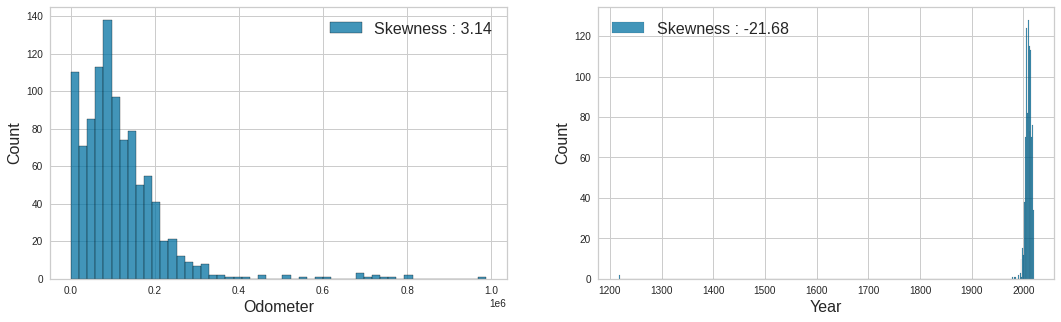

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18,5))
g = sns.histplot(df_train['odometer'], color='b', label='Skewness : {:.2f}'.format(df_train['odometer'].skew()), ax=ax[0])
g.legend(loc='best', prop={'size': 16})
g.set_xlabel("Odometer", fontsize = 16)
g.set_ylabel("Count", fontsize = 16)

g = sns.histplot(df_train['year'], color='b', label='Skewness : {:.2f}'.format(df_train['year'].skew()), ax=ax[1])
g.legend(loc='best', prop={'size': 16})
g.set_xlabel("Year", fontsize = 16)
g.set_ylabel("Count", fontsize = 16)
plt.show()

In [11]:
numeric_fts = ['odometer', 'year']
outlier_ind = []
for i in numeric_fts:
  Q1 = np.percentile(df_train[i],25)
  Q3 = np.percentile(df_train[i],75)
  IQR = Q3-Q1
  outlier_list = df_train[(df_train[i] < Q1 - IQR * 1.5) | (df_train[i] > Q3 + IQR * 1.5)].index
  outlier_ind.extend(outlier_list)

In [12]:
# Drop outliers
train_df = df_train.drop(outlier_ind, axis = 0).reset_index(drop = True)
train_df

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000
...,...,...,...,...,...,...,...,...,...,...,...
970,1010,Toyota Corolla,46768,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2014,5415000
971,1011,Toyota Camry,31600,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Silver,2011,3615000
972,1012,Toyota Camry,96802,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2011,3415000
973,1013,Lexus GX 460,146275,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Gold,2013,14315000


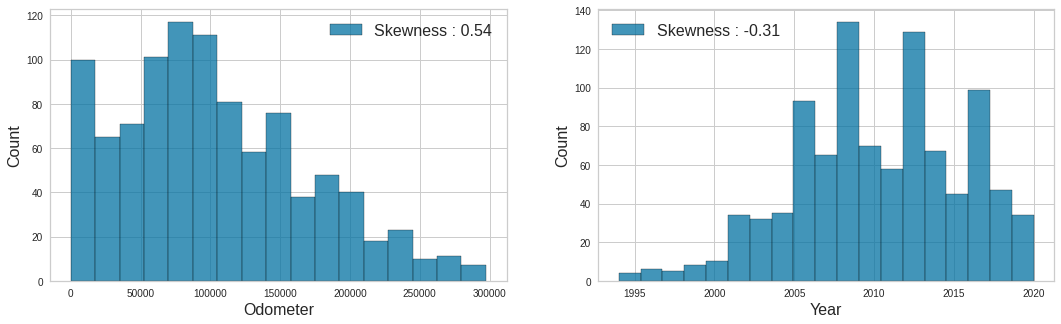

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(18,5))
g = sns.histplot(train_df['odometer'], color='b', label='Skewness : {:.2f}'.format(train_df['odometer'].skew()), ax=ax[0])
g.legend(loc='best', prop={'size': 16})
g.set_xlabel("Odometer", fontsize = 16)
g.set_ylabel("Count", fontsize = 16)

g = sns.histplot(train_df['year'], color='b', label='Skewness : {:.2f}'.format(train_df['year'].skew()), ax=ax[1])
g.legend(loc='best', prop={'size': 16})
g.set_xlabel("Year", fontsize = 16)
g.set_ylabel("Count", fontsize = 16)
plt.show()

- 📝 outlier 들을 제거하여 첨도가 감소했습니다.

In [14]:
print("# outliers to drop :", len(outlier_ind))

# outliers to drop : 44


### 2-(2). Correlation
- 📝 앞서 수행한 pandas profiling report의 alert를 참고하여 상관계수를 계산했습니다.
- 📝 Categorical 데이터를 라벨인코더를 통해 수치형으로 변환한 후 상관관계를 확인합니다.

In [15]:
cat_fts = ['title', 'location', 'isimported', 'engine', 'transmission', 'fuel', 'paint']

In [16]:
la_train = train_df.copy()

for i in range(len(cat_fts)):
  encoder = LabelEncoder()
  la_train[cat_fts[i]] = encoder.fit_transform(la_train[cat_fts[i]])

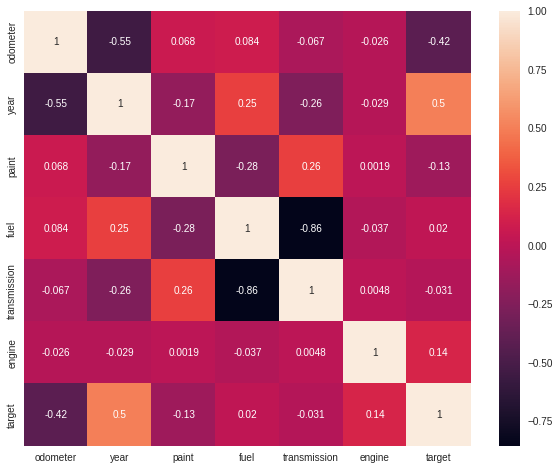

In [17]:
plt.figure(figsize = (10,8))
sns.heatmap(la_train[['odometer', 'year', 'paint', 'fuel', 'transmission', 'engine', 'target']].corr(), annot=True)
plt.show()

## **3. Feature Engineering**

### 3-(1). `company` 컬럼 생성
- 📝 `title` 변수 값들의 앞부분에는 공통적으로 자동차 회사의 이름이 오는것을 확인할 수 있습니다.
- split 함수를 사용하여 첫번째 띄어쓰기를 기준으로 회사명 데이터를 추출하고 새 컬럼을 생성해주겠습니다.
- (수정) `company` 컬럼의 계급을 훈련 데이터의 `target`값 기준으로 나눠주겠습니다.

In [18]:
print(train_df['title'].unique()[:20])

['Toyota RAV 4' 'Toyota Land Cruiser' 'Land Rover Range Rover Evoque'
 'Lexus ES 350' 'Toyota Venza' 'Toyota Corolla'
 'Land Rover Range Rover Sport' 'Pontiac Vibe' 'Toyota Tacoma'
 'Lexus RX 350' 'Ford Escape' 'Honda Civic' 'Volvo XC90' 'BMW 750'
 'Infiniti JX' 'Honda Accord' 'Mercedes-Benz ML 350' 'Toyota Camry'
 'Hyundai Azera' 'Lexus GX 460']


In [19]:
train_df['company'] = train_df['title'].apply(lambda x : x.split(" ")[0])
df_test['company'] = df_test['title'].apply(lambda x : x.split(" ")[0])

print(train_df['company'].unique())
print("#fts :", len(train_df['company'].unique()), '\n')
print(df_test['company'].unique())
print("#fts :", len(df_test['company'].unique()), '\n')

['Toyota' 'Land' 'Lexus' 'Pontiac' 'Ford' 'Honda' 'Volvo' 'BMW' 'Infiniti'
 'Mercedes-Benz' 'Hyundai' 'Jaguar' 'Mitsubishi' 'Nissan' 'Chevrolet'
 'Mazda' 'Lincoln' 'Kia' 'Acura' 'DAF' 'Man' 'Isuzu' 'IVM' 'Porsche'
 'MINI' 'GMC' 'Iveco' 'Scania' 'Volkswagen' 'GAC' 'IVECO' 'Mack' 'Peugeot'
 'Rolls-Royce' 'MAN-VOLKSWAGEN' 'Jeep' 'ALPINA' 'Bentley' 'JMC']
#fts : 39 

['Mercedes-Benz' 'Honda' 'Toyota' 'Iveco' 'Lexus' 'Nissan' 'Volkswagen'
 'Jeep' 'Ford' 'BMW' 'Mack' 'Land' 'Hyundai' 'Peugeot' 'Volvo' 'Infiniti'
 'Acura' 'Man' 'Fiat' 'MINI' 'DAF' 'Mazda' 'Porsche' 'Mitsubishi'
 'Chevrolet' 'Kia' 'Pontiac' 'Rolls-Royce']
#fts : 28 



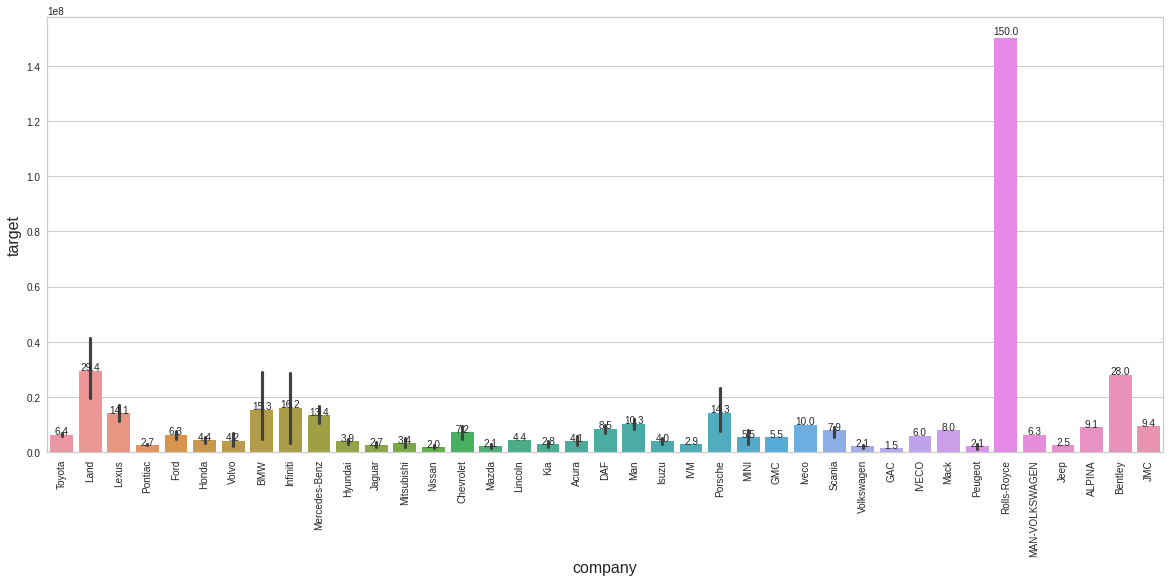

In [20]:
plt.figure(figsize = (20,8))
g = sns.barplot(x = 'company', y = 'target', data = train_df)

for p in g.patches:
    left, bottom, width, height = p.get_bbox().bounds
    g.annotate("%.1f"%(height/1e6), (left+width/2, height*1.01), ha='center')

g.set_xlabel("company", fontsize = 16)
g.set_ylabel("target", fontsize = 16)

plt.xticks(rotation=90)
plt.show()

In [21]:
company_h = np.zeros((len(g.patches)))
i = 0
for p in g.patches:
    left, bottom, width, height = p.get_bbox().bounds
    company_h[i] = (height/1e6)
    i +=1

In [22]:
company_h

array([  6.37849032,  29.39868421,  14.08227273,   2.715     ,
         6.31845588,   4.39417308,   4.15571429,  15.279     ,
        16.16      ,  13.37352941,   3.89282609,   2.665     ,
         3.42      ,   1.98666667,   7.233     ,   2.07875   ,
         4.415     ,   2.81785714,   4.082     ,   8.515     ,
        10.265     ,   4.015     ,   2.89      ,  14.265     ,
         5.54      ,   5.515     ,  10.015     ,   7.93      ,
         2.09409091,   1.49      ,   6.015     ,   8.015     ,
         2.125     , 150.015008  ,   6.34      ,   2.515     ,
         9.065     ,  28.015     ,   9.365     ])

In [23]:
companys = train_df['company'].unique()

In [24]:
def company_fix(train_df, df, companys):
  only_test_com = list(set(df['company'])-set(train_df['company']))


  if len(only_test_com) != 0:
    for k in range(len(only_test_com)):
      print(only_test_com)
      df.loc[(df['company'] == only_test_com[k]), 'company'] = 1


  for c in range(7):
    if c==6:
      company_ind = companys[np.where(company_h>=c*5)]
    elif c==0:
      company_ind = companys[np.where(company_h<(c+1)*5)]
    else:  
      company_ind = companys[np.where((company_h>=c*5)&(company_h<(c+1)*5))]
    
    for i in range(len(company_ind)):
      df.loc[(df['company'] == company_ind[i]), 'company'] = c+1

      

In [25]:
copy_train = train_df.copy()

In [26]:
company_fix(copy_train, train_df, companys)

In [27]:
company_fix(copy_train, df_test, companys)

['Fiat']


In [28]:
train_df['company'].unique()

array([2, 6, 3, 1, 4, 7], dtype=object)

In [29]:
df_test['company'].unique()

array([3, 1, 2, 4, 6, 7], dtype=object)

### 3-(2). `paint`
- 📝 뒤죽박죽인 `paint` 변수를 고쳐주겠습니다.

In [30]:
print(sorted(train.paint.unique()))

[' Black', ' Black/Red', 'Ash', 'Ash and black', 'BLACK', 'Beige', 'Black', 'Black ', 'Black and silver', 'Black sand pearl', 'Black.', 'Blue', 'Blue ', 'Brown', 'Cream', 'Cream ', 'DARK GREY', 'Dark Ash', 'Dark Blue', 'Dark Green', 'Dark Grey', 'Dark ash', 'Dark blue ', 'Dark gray', 'Dark silver ', 'Deep Blue', 'Deep blue', 'GOLD', 'Gery', 'Gold', 'Gold ', 'Gray', 'Gray ', 'Green', 'Green ', 'Grey', 'Grey ', 'Ink blue', 'Light Gold', 'Light blue', 'Light silver ', 'Magnetic Gray', 'Magnetic Gray Metallic', 'Maroon', 'Midnight Black Metal', 'Milk', 'Navy blue', 'Off white', 'Off white l', 'Pale brown', 'Purple', 'Red', 'Redl', 'SILVER', 'Silver', 'Silver ', 'Silver/grey', 'Sky blue', 'Skye blue', 'Sliver', 'Super White', 'WHITE', 'WINE', 'Whine ', 'White', 'White ', 'White orchild pearl', 'Wine', 'Yellow', 'blue', 'green', 'orange', 'red', 'white', 'white-blue', 'yellow']


In [31]:
def color_handling(x):
  x['paint'] = x['paint'].str.strip()   # eliminate empty space
  x['paint'] = x['paint'].str.lower()    # convert to lower case
  x['paint'] = x['paint'].str.replace(".", "")

In [32]:
color_handling(train_df)
color_handling(df_test)

In [33]:
train_df['paint'].unique()

array(['red', 'black', 'gray', 'white', 'blue', 'redl', 'silver',
       'black/red', 'deep blue', 'dark grey', 'brown', 'grey', 'green',
       'purple', 'gold', 'dark blue', 'milk', 'midnight black metal',
       'beige', 'dark ash', 'cream', 'dark gray', 'white orchild pearl',
       'dark green', 'yellow', 'sliver', 'wine', 'white-blue',
       'magnetic gray', 'dark silver', 'silver/grey', 'ink blue',
       'light blue', 'sky blue', 'gery', 'pale brown', 'whine',
       'black and silver', 'light silver', 'black sand pearl',
       'off white', 'ash', 'maroon', 'navy blue', 'super white',
       'ash and black', 'magnetic gray metallic', 'skye blue',
       'off white l'], dtype=object)

- `skye blue` -> `sky blue`
- `dark ash`, `dark grey`, `dark silver`, `ash and black`, `black and silver` -> `dark gray`
- `gery`, `grey`,`ash`, `magnetic gray metallic`, `magnetic gray`, `gray metallic`, `silver/grey`, `sliver`, `silver` -> `gray`
- `off white l`, `off white`, `super white`, `white orchild pearl` -> `white`
- `redl`, `maroon` -> `red`
- `whine` -> `wine`
- `ink blue`, `deep blue`, `navy blue` -> `dark blue`
- `sky blue`, `white-blue` -> `light blue`
- `black sand pearl`, `midnight black metal` -> `black`
- `pale brown` -> `brown`
- `milk` -> `cream`

In [34]:
def color_fix(x):
  x['paint'] = x['paint'].str.replace("skye blue", "sky blue")

  x['paint'] = x['paint'].str.replace("dark ash", "dark gray")
  x['paint'] = x['paint'].str.replace("dark grey", "dark gray")
  x['paint'] = x['paint'].str.replace("dark silver", "dark gray")
  x['paint'] = x['paint'].str.replace("ash and black", "dark gray")
  x['paint'] = x['paint'].str.replace("black and silver", "dark gray")

  x['paint'] = x['paint'].str.replace("gery", "gray")
  x['paint'] = x['paint'].str.replace("grey", "gray")
  x['paint'] = x['paint'].str.replace("ash", "gray")
  x['paint'] = x['paint'].str.replace("silver/grey", "gray")
  x['paint'] = x['paint'].str.replace("silver/gray", "gray")
  x['paint'] = x['paint'].str.replace("sliver", "gray")
  x['paint'] = x['paint'].str.replace("silver", "gray")

  x['paint'] = x['paint'].str.replace("magnetic gray", "gray")
  x['paint'] = x['paint'].str.replace("gray metallic", "gray")
  x['paint'] = x['paint'].str.replace("magnetic gray metallic", "gray")

  x['paint'] = x['paint'].str.replace("black sand pearl", "black")
  x['paint'] = x['paint'].str.replace("midnight black metal", "black")


  x['paint'] = x['paint'].str.replace("off white l", "white")
  x['paint'] = x['paint'].str.replace("off white", "white")
  x['paint'] = x['paint'].str.replace("super white", "white")
  x['paint'] = x['paint'].str.replace("white orchild pearl", "white")

  x['paint'] = x['paint'].str.replace("redl", "red")
  x['paint'] = x['paint'].str.replace("maroon", "red")
  x['paint'] = x['paint'].str.replace("whine", "wine")

  x['paint'] = x['paint'].str.replace("ink blue", "dark blue")
  x['paint'] = x['paint'].str.replace("deep blue", "dark blue")
  x['paint'] = x['paint'].str.replace("navy blue", "dark blue")

  x['paint'] = x['paint'].str.replace("sky blue", "light blue")
  x['paint'] = x['paint'].str.replace("white-blue", "light blue")
  x['paint'] = x['paint'].str.replace("pale brown", "brown")

  x['paint'] = x['paint'].str.replace("milk", "cream")

In [35]:
color_fix(train_df)
color_fix(df_test)

In [36]:
print(sorted(train_df['paint'].unique()))
print(len(train_df['paint'].unique()))

['beige', 'black', 'black/red', 'blue', 'brown', 'cream', 'dark blue', 'dark gray', 'dark green', 'gold', 'gray', 'green', 'light blue', 'light gray', 'purple', 'red', 'white', 'wine', 'yellow']
19


In [37]:
print(sorted(df_test['paint'].unique()))
print(len(df_test['paint'].unique()))

['beige', 'blac', 'black', 'blue', 'brown', 'classic gray met(1f7)', 'cream', 'dark blue', 'dark gray', 'dark green', 'gold', 'golf', 'gray', 'gray and black', 'green', 'indigo ink pearl', 'light gray', 'mint green', 'red', 'white', 'white and green', 'wine', 'yellow']
23


### 3-(3). `location`
- 📝 `location` 변수도 고쳐주겠습니다.

In [38]:
train_df['location'].unique()

array(['Lagos ', 'Lagos', 'Abuja', 'Lagos State', 'Ogun', 'FCT', 'Accra',
       'other', 'Abuja ', 'Abia State', 'Adamawa ', 'Abia', 'Ogun State'],
      dtype=object)

In [39]:
def location_fix(x):
  x['location'] = x['location'].str.replace("Lagos ", "Lagos")
  x['location'] = x['location'].str.replace("Lagos State", "Lagos")
  x['location'] = x['location'].str.replace("Ogun State", "Ogun")
  x['location'] = x['location'].str.replace("Abuja ", "Abuja")
  x['location'] = x['location'].str.replace("Abia State", "Abia")
  x['location'] = x['location'].str.replace("LagosState", "Lagos")

In [40]:
location_fix(train_df)
location_fix(df_test)

In [41]:
print(sorted(train_df['location'].unique()))
print(len(train_df['location'].unique()))

['Abia', 'Abuja', 'Accra', 'Adamawa ', 'FCT', 'Lagos', 'Ogun', 'other']
8


In [42]:
print(sorted(df_test['location'].unique()))
print(len(df_test['location'].unique()))

['Abia', 'Abuja', 'Arepo ogun state ', 'Lagos', 'Mushin', 'Ogun', 'other']
7


### 3-(4). `engine`
- 📝  `engine` 변수를 수치형으로 바꿔주겠습니다.

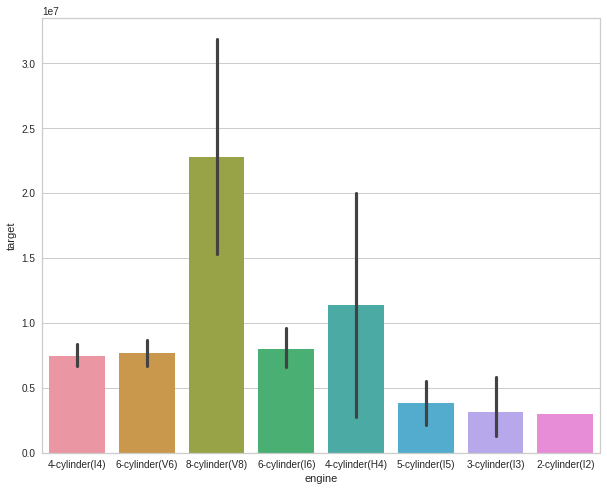

In [43]:
plt.figure(figsize = (10,8))
sns.barplot(x = 'engine', y = 'target', data = train_df)
plt.show()

In [44]:
engines = train_df['engine'].unique()
engines

array(['4-cylinder(I4)', '6-cylinder(V6)', '8-cylinder(V8)',
       '6-cylinder(I6)', '4-cylinder(H4)', '5-cylinder(I5)',
       '3-cylinder(I3)', '2-cylinder(I2)'], dtype=object)

In [45]:
train_df['engine']

0      4-cylinder(I4)
1      4-cylinder(I4)
2      6-cylinder(V6)
3      4-cylinder(I4)
4      6-cylinder(V6)
            ...      
970    4-cylinder(I4)
971    4-cylinder(I4)
972    4-cylinder(I4)
973    6-cylinder(V6)
974    6-cylinder(V6)
Name: engine, Length: 975, dtype: object

In [46]:
def engine_fix(df):
  df.loc[((df['engine'] != "8-cylinder(V8)") & (df['engine'] != "4-cylinder(H4)") & (df['engine'] != "6-cylinder(I6)") & 
          (df['engine'] != "6-cylinder(V6)") & (df['engine'] != "4-cylinder(I4)") & (df['engine'] != "5-cylinder(I5)") & (df['engine'] != "3-cylinder(I3)") & (df['engine'] != "2-cylinder(I2)")), 'engine'] = 2
    
  df.loc[(df['engine'] == "2-cylinder(I2)"), 'engine'] = 1
  df.loc[(df['engine'] == "3-cylinder(I3)"), 'engine'] = 1
  df.loc[(df['engine'] == "5-cylinder(I5)"), 'engine'] = 1
  df.loc[(df['engine'] == "4-cylinder(I4)"), 'engine'] = 2
  df.loc[(df['engine'] == "6-cylinder(V6)"), 'engine'] = 2
  df.loc[(df['engine'] == "6-cylinder(I6)"), 'engine'] = 2
  df.loc[(df['engine'] == "4-cylinder(H4)"), 'engine'] = 3
  df.loc[(df['engine'] == "8-cylinder(V8)"), 'engine'] = 4

In [47]:
engine_fix(train_df)
engine_fix(df_test)

In [48]:
print(sorted(train_df['engine'].unique()))
print(len(train_df['engine'].unique()))

[1, 2, 3, 4]
4


In [49]:
print(sorted(df_test['engine'].unique()))
print(len(df_test['engine'].unique()))

[1, 2, 4]
3


### 3-(5). dropping
- 📝  train과 test 데이터의 `title`, `location`, `paint` 변수의 값 종류 및 길이가 일치하지 않습니다.

In [50]:
cat_fts2 = ['title', 'location', 'isimported', 'transmission', 'fuel', 'paint']

In [51]:
for i in range(len(cat_fts2)):
  print(cat_fts2[i], ":")
  print(train_df[cat_fts2[i]].unique())
  print("#fts :", len(train_df[cat_fts2[i]].unique()), '\n')

title :
['Toyota RAV 4' 'Toyota Land Cruiser' 'Land Rover Range Rover Evoque'
 'Lexus ES 350' 'Toyota Venza' 'Toyota Corolla'
 'Land Rover Range Rover Sport' 'Pontiac Vibe' 'Toyota Tacoma'
 'Lexus RX 350' 'Ford Escape' 'Honda Civic' 'Volvo XC90' 'BMW 750'
 'Infiniti JX' 'Honda Accord' 'Mercedes-Benz ML 350' 'Toyota Camry'
 'Hyundai Azera' 'Lexus GX 460' 'BMW 325' 'Toyota Sienna' 'Honda Fit'
 'Honda CR-V' 'Hyundai Tucson' 'Jaguar XJ8' 'BMW X6' 'Mercedes-Benz C 300'
 'Mitsubishi Galant' 'Mercedes-Benz GL 450' 'Lexus RX 300'
 'Toyota Highlander' 'Mitsubishi CANTER PICK UP' 'Nissan Titan'
 'Lexus IS 250' 'Mercedes-Benz 200' 'Toyota Sequoia' 'Ford Explorer'
 'Hyundai ix35' 'Lexus CT 200h' 'Lexus LX 570' 'Toyota Avensis'
 'Toyota 4-Runner' 'Mercedes-Benz GLE 350' 'Mercedes-Benz E 300'
 'Toyota Avalon' 'Chevrolet Camaro' 'Land Rover Range Rover' 'Mazda CX-9'
 'Lexus RX 330' 'Lincoln Mark' 'Kia Optima' 'Lexus GS 300' 'Jaguar X-Type'
 'Nissan Altima' 'Acura MDX' 'DAF 95XF TRACTOR HEAD' 'Man TGA

In [52]:
for i in range(len(cat_fts2)):
  print(cat_fts2[i], ":")
  print(df_test[cat_fts2[i]].unique())
  print("#fts :", len(df_test[cat_fts2[i]].unique()), '\n')

title :
['Mercedes-Benz C 300' 'Honda Accord' 'Mercedes-Benz S 550'
 'Toyota Sienna' 'Toyota Hiace' 'Toyota Corolla' 'Iveco EUROCARGO 120e18'
 'Mercedes-Benz GLE 350' 'Toyota Highlander' 'Toyota Hilux' 'Toyota Camry'
 'Mercedes-Benz C 180' 'Lexus ES 350' 'Honda Fit' 'Toyota Matrix'
 'Toyota Venza' 'Lexus IS 250' 'Nissan Primera' 'Volkswagen Sharan'
 'Jeep Wrangler' 'Volkswagen Golf' 'Mercedes-Benz 814' 'Nissan Sentra'
 'Volkswagen Passat' 'Mercedes-Benz GLK 350' 'Lexus RX 350' 'Ford Mondeo'
 'BMW X3' 'Mack CXN613 CAB BEHIND ENGINE' 'Toyota RAV 4'
 'Land Rover Discovery' 'Toyota Avalon' 'Lexus GX 460' 'Hyundai Santa Fe'
 'Peugeot 206' 'Volvo FL7' 'Mercedes-Benz C 320' 'Hyundai Sonata'
 'Infiniti FX' 'Honda Civic' 'Mercedes-Benz CLS 500'
 'Mercedes-Benz GLK 300' 'Acura RDX' 'Mercedes-Benz G 550' 'BMW 535'
 'Acura TL' 'Nissan Xterra' 'Land Rover Range Rover' 'Nissan A'
 'Toyota 4-Runner' 'Honda Pilot' 'Man LE 8. 180 PLATFORM TRUCK'
 'Toyota Yaris' 'Hyundai Elantra' 'Volvo S80' 'Mercedes-B

- 📝 One-hot encoding을 진행해줍니다

In [53]:
train_data = train_df.copy()
test_data = df_test.copy()

In [54]:
for i in range(len(cat_fts2)):
  onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse = False)

  transformed = onehot_encoder.fit_transform(train_data[cat_fts2[i]].to_numpy().reshape(-1, 1))
  onehot_df = pd.DataFrame(transformed, columns=onehot_encoder.get_feature_names())
  train_data = pd.concat([train_data, onehot_df], axis=1).drop(cat_fts2[i], axis=1)

  test_transformed = onehot_encoder.transform(test_data[cat_fts2[i]].to_numpy().reshape(-1, 1))
  test_onehot_df = pd.DataFrame(test_transformed, columns=onehot_encoder.get_feature_names())
  test_data = pd.concat([test_data, test_onehot_df], axis=1).drop(cat_fts2[i], axis=1)

In [55]:
print(train_data.columns)
print(test_data.columns)

Index(['id', 'odometer', 'engine', 'year', 'target', 'company', 'x0_ALPINA B3',
       'x0_Acura MDX', 'x0_Acura RDX', 'x0_Acura TL',
       ...
       'x0_gold', 'x0_gray', 'x0_green', 'x0_light blue', 'x0_light gray',
       'x0_purple', 'x0_red', 'x0_white', 'x0_wine', 'x0_yellow'],
      dtype='object', length=225)
Index(['id', 'odometer', 'engine', 'year', 'company', 'x0_ALPINA B3',
       'x0_Acura MDX', 'x0_Acura RDX', 'x0_Acura TL', 'x0_Acura ZDX',
       ...
       'x0_gold', 'x0_gray', 'x0_green', 'x0_light blue', 'x0_light gray',
       'x0_purple', 'x0_red', 'x0_white', 'x0_wine', 'x0_yellow'],
      dtype='object', length=224)


- 📝 train 데이터의 target 컬럼을 제외하고는 train과 test의 열길이가 같도록 one-hot encoding이 잘 진행된것을 확인할 수 있습니다.

In [56]:
train_x = train_data.drop('id', axis = 1)
test_x = test_data.drop('id', axis = 1)

print(train_x.shape)
print(test_x.shape)

(975, 224)
(436, 223)


## **4. Modeling**
- pycaret을 활용했습니다.

In [57]:
py_reg = setup(train_x, target = 'target', session_id = seed_num, silent = True)

,Description,Value
0,session_id,42
1,Target,target
2,Original Data,"(975, 224)"
3,Missing Values,False
4,Numeric Features,35
5,Categorical Features,188
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(682, 226)"


In [ ]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,2.052122e+06,3.032507e+13,4.874472e+06,7.763000e-01,0.3940,2.705000e-01,5.786
gbr,Gradient Boosting Regressor,2.215648e+06,3.169851e+13,4.992229e+06,7.507000e-01,0.3991,3.435000e-01,0.201
rf,Random Forest Regressor,2.132068e+06,3.173878e+13,4.964929e+06,7.477000e-01,0.3567,2.637000e-01,0.797
et,Extra Trees Regressor,2.235193e+06,3.563028e+13,5.401867e+06,7.073000e-01,0.3660,2.627000e-01,0.872
ridge,Ridge Regression,3.439487e+06,4.245590e+13,5.963903e+06,6.569000e-01,0.8327,9.147000e-01,0.036
dt,Decision Tree Regressor,2.503733e+06,3.621137e+13,5.587945e+06,6.550000e-01,0.4376,2.988000e-01,0.027
omp,Orthogonal Matching Pursuit,3.249912e+06,4.415962e+13,6.123065e+06,6.337000e-01,0.8006,7.729000e-01,0.020
lr,Linear Regression,3.577824e+06,4.495084e+13,6.188975e+06,6.291000e-01,0.7927,9.623000e-01,0.349
llar,Lasso Least Angle Regression,3.479438e+06,4.552524e+13,6.215977e+06,6.243000e-01,0.8050,9.201000e-01,0.084
lasso,Lasso Regression,3.562897e+06,4.500952e+13,6.206766e+06,6.219000e-01,0.7581,9.474000e-01,0.072


In [ ]:
catboost = create_model('catboost', verbose = False)
rf = create_model('rf', verbose = False)
gbr = create_model('gbr', verbose = False)

- 📝 상위 3개의 모델을 혼합한 모델을 생성합니다.

In [ ]:
blended_model = blend_models(estimator_list = [catboost, rf, gbr])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.368465e+06,1.239934e+14,1.113523e+07,0.6025,0.3779,0.3052
1,1.523530e+06,7.672571e+12,2.769941e+06,0.8638,0.3379,0.2818
2,1.430990e+06,6.330266e+12,2.516002e+06,0.8527,0.3042,0.2395
3,1.205003e+06,6.456912e+12,2.541045e+06,0.7147,0.3131,0.2569
4,2.395485e+06,2.857651e+13,5.345700e+06,0.6260,0.3721,0.3061
5,3.142842e+06,6.432011e+13,8.019982e+06,0.5683,0.3675,0.2571
6,1.753312e+06,1.835539e+13,4.284319e+06,0.8353,0.3038,0.2304
7,1.810014e+06,2.096415e+13,4.578662e+06,0.8783,0.3255,0.2637
8,1.982680e+06,1.493599e+13,3.864710e+06,0.8744,0.3505,0.2618


- 📝 전체 데이터로 마지막 학습을 진행하고 test 예측을 생성합니다.

In [ ]:
final_model = finalize_model(blended_model)
prediction = predict_model(final_model, data = test_x)

In [ ]:
pred = prediction['Label']

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Forecasting_price/dataset/sample_submission.csv')
submission['target'] = pred

submission.to_csv('/content/drive/MyDrive/Forecasting_price/pycaret_new4.csv', index=False)

읽어주셔서 감사합니다 :)  
도움이 됐길 바랍니다👍👍